# Imports

In [1]:
import sys
import copy
import numpy as np
from model.base import CovidModel, SimulationParameters, set_parameters, normal_ci
from utils import BasicStatistics, AddPolicy, RemovePolicy, Propaganda, setup_city_layout, AddPolicyInfectedRate, confidence_interval, multiple_runs
from model.utils import SocialPolicy
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import timedelta

## Real Data

### NYTimes Dataset

<AxesSubplot:xlabel='date'>

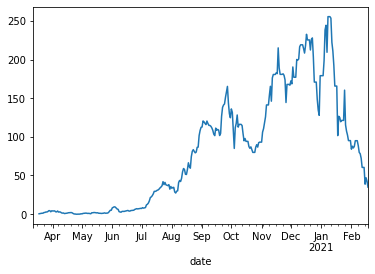

In [2]:
us_counties = pd.read_csv("./data/us-counties.csv")
us_counties = us_counties.loc[(us_counties.county == 'Greene') & (us_counties.state == 'Missouri')]
us_counties.index = pd.to_datetime(us_counties['date'])
assert sum(us_counties.fips == 29077.0) == us_counties.shape[0]
us_counties.drop(columns=['county', 'state', 'date', 'fips'], inplace=True)
us_counties['daily_cases'] = np.concatenate(([0], us_counties.cases[1:].values - us_counties.cases[:-1].values))
us_counties['mean_daily_cases'] = us_counties['daily_cases'].rolling(7).mean()
us_counties.mean_daily_cases.plot()

# Simulation

## Greene LockDown Parameters

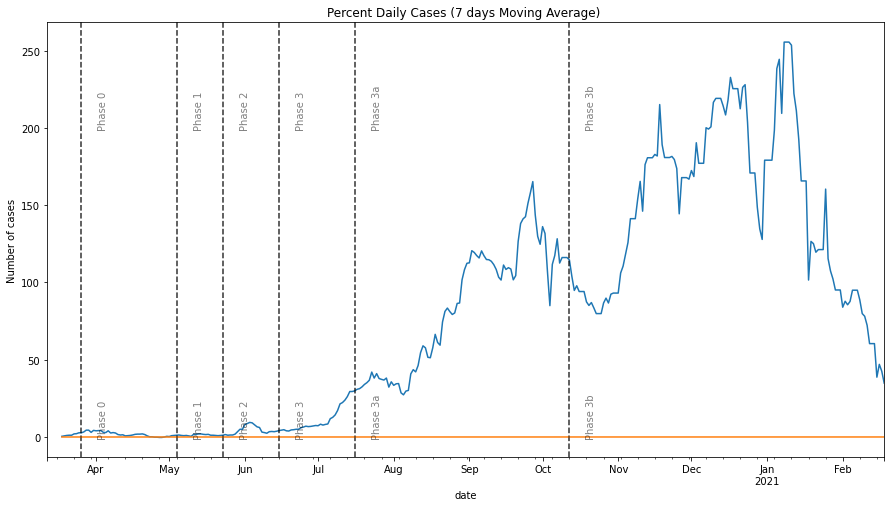

In [3]:
start_date = us_counties.iloc[0]._name

s = pd.to_datetime(
    pd.Series(['3/26/2020', 
               '5/4/2020', 
               '5/23/2020', 
               '6/15/2020', 
               '7/16/2020', 
               '10/12/2020', 
               #'1/10/2021'
              ]))

abs_dates = s - start_date
dates_df = pd.DataFrame(s)
dates_df['phase'] = ['0', '1', '2', '3', '3a','3b', 
                     #'4'
                    ]
dates_df['num_days'] = abs_dates.apply(lambda x: int(x.days))
dates_df.columns = ['date', 'phase', 'num_days']

START = 0
PHASE_0 = 14
PHASE_1 = 53
PHASE_2 = 72
PHASE_3 = 95
PHASE_3a = 126
PHASE_3b = 214

delta = timedelta(days=7)

us_counties.mean_daily_cases.plot(figsize=(15, 8))
plt.title("Daily Cases (7 days Moving Average) ")
plt.ylabel("Number of cases")
for i, phase in dates_df[['date', 'phase']].iterrows():
    plt.axvline(phase['date'], color='k', linestyle='--', alpha=0.5)
    plt.text(phase['date'] + delta, 200, 'Phase ' + phase['phase'], rotation=90, alpha = 0.5)

us_counties.dropna(inplace=True)
us_counties.index.min()

num_days = us_counties.index.max() - us_counties.index.min()
num_days = num_days.days + 1

greene_population = 293086

us_counties['percent_daily_cases'] = np.round(100 * us_counties.mean_daily_cases/greene_population, 5)
us_counties['percent_daily_cases'].plot(figsize=(15, 8))
plt.title("Percent Daily Cases (7 days Moving Average) ")
plt.ylabel("Number of cases")
for i, phase in dates_df[['date', 'phase']].iterrows():
    plt.axvline(phase['date'], color='k', linestyle='--', alpha=0.5)
    plt.text(phase['date'] + delta, 0.07, 'Phase ' + phase['phase'], rotation=90, alpha = 0.5)

## Parameters settings

In [11]:
listeners = [
    ["AddPolicy", SocialPolicy.LOCKDOWN_RETAIL, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_FACTORY, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_OFFICE, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_HOUSEBOUND, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_ELEMENTARY_SCHOOL, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_MIDDLE_SCHOOL, START],
    ["AddPolicy", SocialPolicy.LOCKDOWN_HIGH_SCHOOL, START],
    
    ["RemovePolicy", SocialPolicy.LOCKDOWN_ELEMENTARY_SCHOOL, PHASE_3],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_MIDDLE_SCHOOL, PHASE_3],
    
    ["RemovePolicy", SocialPolicy.LOCKDOWN_FACTORY, PHASE_3a],
    
    ["RemovePolicy", SocialPolicy.LOCKDOWN_RETAIL, PHASE_3b],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_OFFICE, PHASE_3b],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_HOUSEBOUND, PHASE_3b],
    ["RemovePolicy", SocialPolicy.LOCKDOWN_HIGH_SCHOOL, PHASE_3b],
]

common_parameters = SimulationParameters(
    mask_user_rate = 0.9,
    mask_efficacy = 0.6,
    imune_rate = 0.01,
#     initial_infection_rate = 0.0005,
    initial_infection_rate = 0.05,
    hospitalization_capacity = 0.05,
    latency_period_shape = 3,
    latency_period_scale = 1, 
    incubation_period_shape = 6,
    incubation_period_scale = 1, 
    mild_period_duration_shape = 14,
    mild_period_duration_scale = 1,
    hospitalization_period_duration_shape = 12,
    hospitalization_period_duration_scale = 1,
    symptomatic_isolation_rate = 0.0,
    asymptomatic_contagion_probability = 0.1,
#    asymptomatic_contagion_probability = 0.05,
#     risk_tolerance_mean = 0.7,
    risk_tolerance_mean = 0.2,
    risk_tolerance_stdev = 0.2,
    herding_behavior_mean = 0.7,
#    herding_behavior_mean = 0.1,
    herding_behavior_stdev = 0.2,
    allowed_restaurant_capacity = 0.25, #1.0, # valid values: {1.0, 0.50, 0.25}
    spreading_rate = normal_ci(2.41, 3.90, 20)
#    spreading_rate = normal_ci(0.5, 1.5, 20)
)

sc = 10

population_size = 1500
simulation_cycles = num_days # days
seed = 31415
np.random.seed(seed)

params = copy.deepcopy(common_parameters)

greene_demographics = {
    'total_population': 293086,
    'age_distribution':{
        4: 6.0,
        9: 5.7,
        14: 5.8,
        19: 6.5,
        24: 10.6,
        34: 14.1,
        44: 11.7,
        54: 11.5,
        59: 6.0,
        64: 6.0,
        74: 8.9,
        84: 5.0,
        100: 2.1
    },
}

Save these seeds if you want to rerun a scenario
[9675]
Average similarity between family members is 0.9999556546895796 at temperature -1
Average similarity between family and home is 0.9999522191951465 at temperature -1
Average similarity between students and their classroom is 0.9999317475199628 at temperature -1
Average classroom occupancy is 13.71875 and number classrooms is 32
Average similarity between workers is 0.9999372406873156 at temperature -1
Average office occupancy is 10.322916666666666 and number offices is 96
Average friend similarity for adults: 0.9999252641130802 for kids: 0.9999200200540685
home_districts
[
Home (0,0) district with 30 Buildings
HomogeneousBuilding: 20 units (each with capacity for 5 people.) 19 allocated units with a total of 61 people.
HomogeneousBuilding: 20 units (each with capacity for 5 people.) 17 allocated units with a total of 58 people.
HomogeneousBuilding: 20 units (each with capacity for 5 people.) 19 allocated units with a total of 54 pe

disconnects
0.0
clumpiness 10.17
maxlen 15
disconnects
0.99
clumpiness 79.22
maxlen 2
avg restaurant similarity 0.9998826140658522
disconnects
1.0
clumpiness 80.0
maxlen 0
avg restaurant similarity 0.9998322573286352
disconnects
1.0
clumpiness 80.0
maxlen 0
avg restaurant similarity 0.999867478782602
disconnects
1.0
clumpiness 80.0
maxlen 0
avg restaurant similarity 0.9998552860637917
disconnects
1.0
clumpiness 80.0
maxlen 0
avg restaurant similarity 0.9998903033548994
disconnects
1.0
clumpiness 80.0
maxlen 0
avg restaurant similarity 0.9998009665370368
disconnects
1.0
clumpiness 80.0
maxlen 0
avg restaurant similarity 0.999815384731726
disconnects
1.0
clumpiness 80.0
maxlen 0
avg restaurant similarity 0.9998165157365926
disconnects
1.0
clumpiness 80.0
maxlen 0
avg restaurant similarity 0.9998584691235712
disconnects
0.99
clumpiness 79.25
maxlen 5
avg restaurant similarity 0.9998390077858864
disconnects
1.0
clumpiness 80.0
maxlen 0
avg restaurant similarity 0.999813702825505
disconnect

disconnects
0.78
clumpiness 65.43
maxlen 25
avg restaurant similarity 0.9998092135700749
disconnects
0.8
clumpiness 66.83
maxlen 27
avg restaurant similarity 0.9998557345336252
disconnects
0.74
clumpiness 63.2
maxlen 31
avg restaurant similarity 0.999806358004773
disconnects
0.84
clumpiness 69.34
maxlen 21
avg restaurant similarity 0.9997995659253508
disconnects
0.75
clumpiness 63.71
maxlen 26
avg restaurant similarity 0.9998386819897783
disconnects
0.76
clumpiness 64.08
maxlen 27
avg restaurant similarity 0.9998452520895672
disconnects
0.7
clumpiness 60.98
maxlen 29
avg restaurant similarity 0.9998105218232354
disconnects
0.73
clumpiness 63.02
maxlen 35
avg restaurant similarity 0.999843015773138
disconnects
0.74
clumpiness 63.2
maxlen 26
avg restaurant similarity 0.9998739887608522
disconnects
0.78
clumpiness 65.88
maxlen 35
avg restaurant similarity 0.9998383717475653
disconnects
0.77
clumpiness 65.07
maxlen 23
avg restaurant similarity 0.9998575719210268
disconnects
0.71
clumpiness

disconnects
0.78
clumpiness 65.6
maxlen 29
avg restaurant similarity 0.9998466087430445
disconnects
0.82
clumpiness 68.29
maxlen 27
avg restaurant similarity 0.9998512272373568
disconnects
0.74
clumpiness 63.12
maxlen 26
avg restaurant similarity 0.9998873608252851
disconnects
0.67
clumpiness 58.93
maxlen 27
avg restaurant similarity 0.999856236075694
disconnects
0.83
clumpiness 68.84
maxlen 22
avg restaurant similarity 0.9998312647852442
disconnects
0.72
clumpiness 61.94
maxlen 25
avg restaurant similarity 0.9998593531639245
disconnects
0.79
clumpiness 66.36
maxlen 29
avg restaurant similarity 0.9998432864188777
disconnects
0.76
clumpiness 64.15
maxlen 25
avg restaurant similarity 0.9998885388692264
disconnects
0.73
clumpiness 62.59
maxlen 29
avg restaurant similarity 0.9998304895784944
disconnects
0.83
clumpiness 69.35
maxlen 27
avg restaurant similarity 0.9998170177060244
disconnects
0.78
clumpiness 65.78
maxlen 30
avg restaurant similarity 0.9998874330557493
disconnects
0.7
clumpin

disconnects
0.0
clumpiness 10.09
maxlen 17
avg restaurant similarity 0.9998078869862294
disconnects
0.0
clumpiness 10.08
maxlen 17
avg restaurant similarity 0.9998453836104111
disconnects
0.01
clumpiness 10.86
maxlen 18
avg restaurant similarity 0.9998152622731867
disconnects
0.0
clumpiness 9.64
maxlen 13
avg restaurant similarity 0.9998067941084995
disconnects
0.0
clumpiness 9.98
maxlen 16
avg restaurant similarity 0.9998844544948517
disconnects
0.58
clumpiness 50.73
maxlen 19
avg restaurant similarity 0.999857731405025
disconnects
0.02
clumpiness 11.18
maxlen 17
avg restaurant similarity 0.9998584842666016
disconnects
0.01
clumpiness 10.13
maxlen 16
avg restaurant similarity 0.9998570363694462
disconnects
0.0
clumpiness 10.2
maxlen 16
avg restaurant similarity 0.999819134149065
disconnects
0.01
clumpiness 10.34
maxlen 18
avg restaurant similarity 0.9997545844704199
disconnects
0.0
clumpiness 9.51
maxlen 15
avg restaurant similarity 0.9998279328738207
disconnects
0.0
clumpiness 9.96
m

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


using average of time series:
stats on susceptible:
data: [0.7902623274161735]
min:
0.7902623274161735
max:
0.7902623274161735
std:
0.0
mean:
0.7902623274161735
median:
0.7902623274161735
95% confidence interval for the mean:
(nan,nan)
using average of time series:
stats on infected:
data: [0.013747534516765287]
min:
0.013747534516765287
max:
0.013747534516765287
std:
0.0
mean:
0.013747534516765287
median:
0.013747534516765287
95% confidence interval for the mean:
(nan,nan)
using average of time series:
stats on recovered:
data: [0.18252662721893492]
min:
0.18252662721893492
max:
0.18252662721893492
std:
0.0
mean:
0.18252662721893492
median:
0.18252662721893492
95% confidence interval for the mean:
(nan,nan)
using average of time series:
stats on hospitalization:
data: [0.0018974358974358973]
min:
0.0018974358974358973
max:
0.0018974358974358973
std:
0.0
mean:
0.0018974358974358973
median:
0.0018974358974358973
95% confidence interval for the mean:
(nan,nan)
using average of time serie

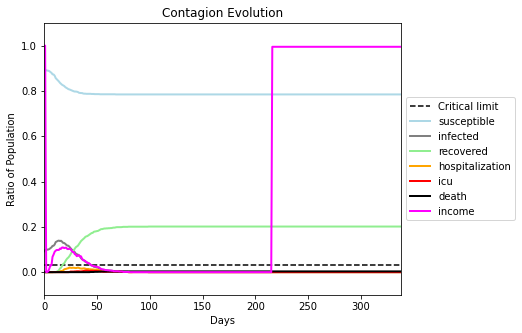

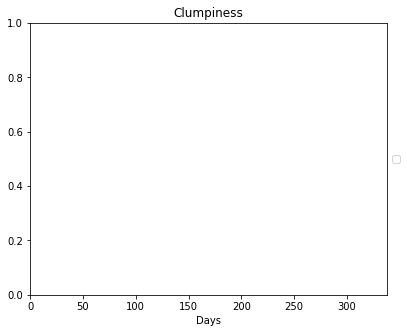

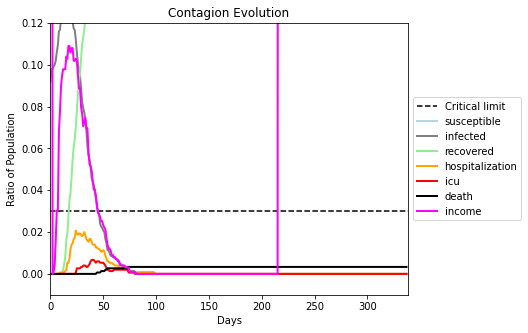

In [12]:
%%time
import logging
def setLevel(level):
    logger1 = logging.getLogger()
    logger1.setLevel(level)

seeds = [9675]
#seeds = [14568, 31221, 63168, 76414, 65369, 15407,  6812, 85182, 17096,
#         50499,  5681, 24521, 34752, 91576, 91228, 69453,  2126, 83567,
#         1565, 14436]
setLevel(logging.CRITICAL)
lower, average, upper, color, statistics, avg,  last,  peak = multiple_runs(
    params,
    population_size,
    simulation_cycles,
    seeds = seeds,
    fname = "ramon",
    do_print = True, 
    desired_stats = ["susceptible", "infected", "recovered", "hospitalization", "icu", "death", "income"],
    listeners = listeners,
    demographics = greene_demographics
)

Text(2021-01-01 00:00:00, nan, 'Christmas')

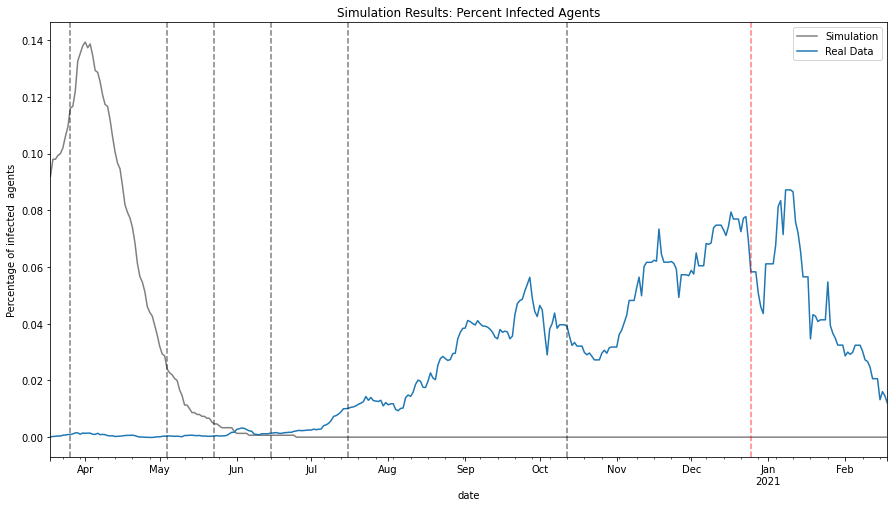

In [13]:
infected_df = pd.DataFrame(
    {'lower': lower['infected'],
    'average': average['infected'],
    'upper': upper['infected']}
)
infected_df.index = us_counties.index

stat = 'infected'
fig, ax = plt.subplots(figsize=(15,8))
infected_df.average.plot(ax = ax, color=color[stat])
us_counties['percent_daily_cases'].plot(ax=ax)
ax.plot(infected_df.index, infected_df.upper, color=color[stat], linewidth=.3)
ax.plot(infected_df.index, infected_df.lower, color=color[stat], linewidth=.3) #mean curve.
ax.fill_between(infected_df.index, infected_df.lower, infected_df.upper, color=color[stat], alpha=.1) #std curves.

plt.title("Simulation Results: Percent Infected Agents")
plt.legend(['Simulation', 'Real Data'])
plt.ylabel("Percentage of infected  agents")
for i, phase in dates_df[['date', 'phase']].iterrows():
    plt.axvline(phase['date'], color='k', linestyle='--', alpha=0.5)
    plt.text(phase['date'] + delta, 0.9*np.max(infected_df['upper']), 'Phase ' + phase['phase'], rotation=90, alpha = 0.5)

CHRISTMAS = pd.to_datetime('25-12-2020')
plt.axvline(CHRISTMAS, color='red', linestyle='--', alpha=0.5)
plt.text(CHRISTMAS + delta, 0.9 * np.max(infected_df['upper']), 'Christmas', color='red', rotation=90, alpha = 0.5)

Text(2021-01-01 00:00:00, 0.0006, 'Christmas')

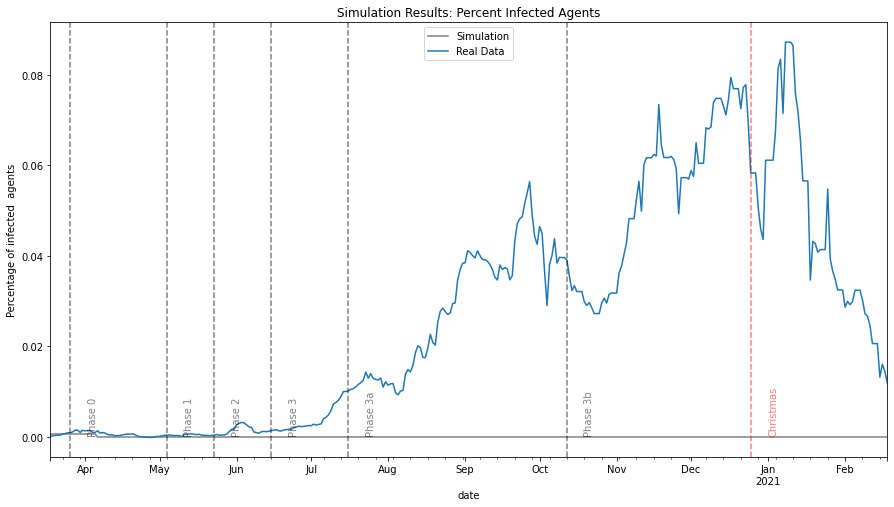

In [9]:
stat = 'infected'
fig, ax = plt.subplots(figsize=(15,8))
infected_df.average.plot(ax = ax, color=color[stat])
us_counties['percent_daily_cases'].plot(ax=ax)

plt.title("Simulation Results: Percent Infected Agents")
plt.legend(['Simulation', 'Real Data'])
plt.ylabel("Percentage of infected  agents")
for i, phase in dates_df[['date', 'phase']].iterrows():
    plt.axvline(phase['date'], color='k', linestyle='--', alpha=0.5)
    plt.text(phase['date'] + delta, 0.9*np.max(infected_df['average']), 'Phase ' + phase['phase'], rotation=90, alpha = 0.5)

CHRISTMAS = pd.to_datetime('25-12-2020')
plt.axvline(CHRISTMAS, color='red', linestyle='--', alpha=0.5)
plt.text(CHRISTMAS + delta, 0.9 * np.max(infected_df['average']), 'Christmas', color='red', rotation=90, alpha = 0.5)